In [1]:
% matplotlib notebook
import json
from utils import *

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from scipy.signal import wiener

import math
import scipy

from kalman_filtering import oneIterPowerKalmanFilter

from indicator_simulation import *

/Users/stranot/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<IPython.core.display.Javascript object>


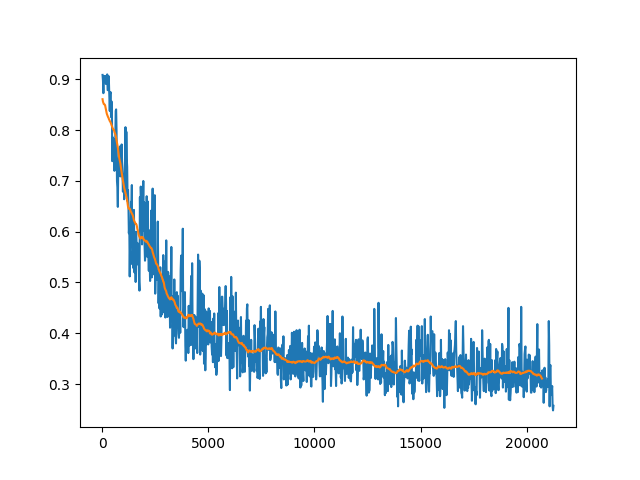

20720 0.31076363758607345 1036
9640 0.3468363686041398


In [18]:
# data_file = 'jsons/val_err_wo_lr_decay.json'
# data_file = 'jsons/val_err.json'
data_file = 'jsons/bs_32_val_err.json'
# data_file = 'jsons/imagenet_dataset0.json'
# data_file = 'jsons/cifar_all_lr_5e_2.json'
# data_file = 'jsons/cifar_all_lr_1e_1.json'
# data_file = 'jsons/cifar_all_lr_8e_2.json'

with open(data_file) as f:
    val_acc = json.load(f)

val_err = 1 - np.array(val_acc)
num_epochs_between_eval = 20
min_delta = 5e-4
patience = 10
# steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval

smooth_win_size = 55
whole_smoothed_val_err = smooth_by_linear_filter(val_err, smooth_win_size)
plt.figure()
plt.plot((np.arange(len(val_err)) + 1)*num_epochs_between_eval, val_err)
plt.plot((np.arange(len(whole_smoothed_val_err)) + 1)*num_epochs_between_eval, whole_smoothed_val_err)

minEpoch = (np.argmin(whole_smoothed_val_err)+1)*num_epochs_between_eval
print(minEpoch, np.min(whole_smoothed_val_err), len(whole_smoothed_val_err))
earlyStoppingStep = early_stopping_step(val_err, min_delta, patience, smooth_win_size, num_epochs_between_eval )
print(earlyStoppingStep, whole_smoothed_val_err[earlyStoppingStep//num_epochs_between_eval+1])


In [19]:
'''
common parametes
'''
pred_win_size = 1000 # large enough to include all the points curretly acquired
left_tail_size = 0
period = 20
start_point = 5
num_samples = 100
upper_limit = 2e5 # it's acually equivalent to setting no upper limit because 2e5 is larger enough
noise_est_win_size = 300
pure_regression_on_linear_end=2000
pure_power_regression_begin=5000
# if min_delta < 7e-4:
#     min_delta = 7e-4

# '''
# result list
# '''
# all_preds = {'Power regression':None, 'Power + linear regression': None, 'Kalman filtering': None}
# all_errs = {'Power regression':None, 'Power + linear regression': None, 'Kalman filtering': None}
# all_steps = {'Power regression':None, 'Power + linear regression': None, 'Kalman filtering': None}
all_preds = {}
all_errs = {}
all_steps = {}


In [20]:
# '''
# power_regression
# '''
# bnds = ((0, None), (None, 0), (None,None))
# inits = (1,0,0)

# # using unsmoothed data; estimate the noise by newest points
# preds, coeffs, shifts, samples, smoothed_samples, CIs, _, steps = powerRegressionIndicator(
#                                     earlyStoppingStep,
#                                     val_err,
#                                     smooth_win_size,
#                                      num_epochs_between_eval, 
#                                      min_delta,
#                                      patience,
#                                     pred_win_size = pred_win_size,
#                                     left_tail_size = left_tail_size,
#                                     weights_type='linear',
#                                     period = period,
#                                     is_power_linear=False,
#                                     bounds=bnds, inits=inits,
#                                     start_point = start_point,
#                                     num_samples=num_samples,
#                                     upper_limit=upper_limit,
#                                     is_fit_smoothed=True,
#                                     noise_est_win_size = noise_est_win_size,)
# #                                     pure_regression_on_linear_end=pure_regression_on_linear_end,
# #                                     pure_power_regression_begin=pure_power_regression_begin)
# print(len(preds))
# errs = CIs2errs(CIs)
# all_preds['Power regression + smoothed'] = preds
# all_errs['Power regression + smoothed'] = errs
# all_steps['Power regression + smoothed'] = steps

In [21]:
# '''
# power + linear regression
# '''
# bnds = ((0, None), (None, 0), (None, None))
# inits = (1,0,0)

# # using unsmoothed data; estimate the noise by newest points
# preds, coeffs, shifts, samples, smoothed_samples, CIs, _, steps = powerRegressionIndicator(
#                                     earlyStoppingStep,
#                                     val_err,
#                                     smooth_win_size,
#                                      num_epochs_between_eval, 
#                                      min_delta,
#                                      patience,
#                                     pred_win_size = pred_win_size,
#                                     left_tail_size = left_tail_size,
#                                     weights_type='linear',
#                                     period = period,
#                                     is_power_linear=True,
#                                     bounds=bnds, inits=inits,
#                                     start_point = start_point,
#                                     num_samples=num_samples,
#                                     upper_limit=upper_limit,
#                                     is_fit_smoothed=True,
#                                     noise_est_win_size = noise_est_win_size,)
# #                                     pure_regression_on_linear_end=pure_regression_on_linear_end,
# #                                     pure_power_regression_begin=pure_power_regression_begin)
# print(len(preds))
# errs = CIs2errs(CIs)
# all_preds['Power + linear regression + smoothed'] = preds
# all_errs['Power + linear regression + smoothed'] = errs
# all_steps['Power + linear regression + smoothed'] = steps

In [22]:
'''
power_regression
'''
bnds = ((0, None), (None, 0), (None,None))
inits = (1,0,0)

# using unsmoothed data; estimate the noise by newest points
preds, coeffs, shifts, samples, smoothed_samples, CIs, _, steps = powerRegressionIndicator(
                                    earlyStoppingStep,
                                    val_err,
                                    smooth_win_size,
                                     num_epochs_between_eval, 
                                     min_delta,
                                     patience,
                                    pred_win_size = pred_win_size,
                                    left_tail_size = left_tail_size,
                                    weights_type='linear',
                                    period = period,
                                    is_power_linear=False,
                                    bounds=bnds, inits=inits,
                                    start_point = start_point,
                                    num_samples=num_samples,
                                    upper_limit=upper_limit,
                                    is_fit_smoothed=False,
                                    noise_est_win_size = noise_est_win_size,)
#                                     pure_regression_on_linear_end=pure_regression_on_linear_end,
#                                     pure_power_regression_begin=pure_power_regression_begin)
print(len(preds))
errs = CIs2errs(CIs)
all_preds['Power regression'] = preds
all_errs['Power regression'] = errs
all_steps['Power regression'] = steps

Global Step: 100
Predicted Stopping epoch is 367.6. a = 0.9222031270312845, b = -0.00703547707568677, d^2=0
Global Step: 500
Predicted Stopping epoch is 2773.2. a = 1.0381235051784528, b = -0.03263279162747271, d^2=0
Global Step: 900
Predicted Stopping epoch is 7476.6. a = 1.3030438512854106, b = -0.08011684140325886, d^2=0
Global Step: 1300
Predicted Stopping epoch is 9287.6. a = 1.479294043657682, b = -0.10414031602384916, d^2=0
Global Step: 1700
Predicted Stopping epoch is 12483.4. a = 1.8806281813542778, b = -0.1478529354902197, d^2=0
Global Step: 2100
Predicted Stopping epoch is 12968.6. a = 1.9100533898540908, b = -0.1506464619362362, d^2=0
Global Step: 2500
Predicted Stopping epoch is 10770.2. a = 1.974685460064035, b = -0.1563205699844108, d^2=0
Global Step: 2900
Predicted Stopping epoch is 11839.6. a = 2.2081698950163418, b = -0.17485686461987482, d^2=0
Global Step: 3300
Predicted Stopping epoch is 13242.6. a = 2.4096706267632886, b = -0.18905694871896256, d^2=0
Global Step: 3

In [23]:
'''
power + linear regression
'''
bnds = ((0, None), (None, 0), (None, None))
inits = (1,0,0)

# using unsmoothed data; estimate the noise by newest points
preds, coeffs, shifts, samples, smoothed_samples, CIs, _, steps = powerRegressionIndicator(
                                    earlyStoppingStep,
                                    val_err,
                                    smooth_win_size,
                                     num_epochs_between_eval, 
                                     min_delta,
                                     patience,
                                    pred_win_size = pred_win_size,
                                    left_tail_size = left_tail_size,
                                    weights_type='linear',
                                    period = period,
                                    is_power_linear=True,
                                    bounds=bnds, inits=inits,
                                    start_point = start_point,
                                    num_samples=num_samples,
                                    upper_limit=upper_limit,
                                    is_fit_smoothed=False,
                                    noise_est_win_size = noise_est_win_size,)
#                                     pure_regression_on_linear_end=pure_regression_on_linear_end,
#                                     pure_power_regression_begin=pure_power_regression_begin)
print(len(preds))
errs = CIs2errs(CIs)
all_preds['Power + linear regression'] = preds
all_errs['Power + linear regression'] = errs
all_steps['Power + linear regression'] = steps

Global Step: 100
Predicted Stopping epoch is 340.0. a = 0.9228814210672677, b = -0.00828990283663475, d^2=9.063115754286311e-05
Global Step: 500
Predicted Stopping epoch is 2458.8. a = 1.0266630211257888, b = -0.030388485587847285, d^2=8.668543346816368e-15
Global Step: 900
Predicted Stopping epoch is 6485.8. a = 1.2502446831625527, b = -0.07264342255242036, d^2=4.744834006930369e-16
Global Step: 1300
Predicted Stopping epoch is 8594.4. a = 1.3771893849343324, b = -0.09197991866012416, d^2=1.8302818887799472e-13
Global Step: 1700
Predicted Stopping epoch is 11253.6. a = 1.6207214633094527, b = -0.12362765879926405, d^2=3.1076960987991974e-15
Global Step: 2100
Predicted Stopping epoch is 10762.0. a = 1.6692464573803187, b = -0.12925751075494088, d^2=2.5609843791263966e-14
Global Step: 2500
Predicted Stopping epoch is 10221.0. a = 1.7201822900232044, b = -0.13491300357219205, d^2=4.655108450349737e-12
Global Step: 2900
Predicted Stopping epoch is 11645.0. a = 1.8476074171652934, b = -0.1

/Users/stranot/qfdong/research/Early_stopping/simulate_online_regression/indicator_simulation.py:211: RuntimeWarning: divide by zero encountered in log
  fun = lambda x: np.sum(np.power(y-(np.exp(x[1]*np.log(steps)+np.log(x[0]))+x[2]**2*(steps-steps[0])),2))


Predicted Stopping epoch is 11059.6. a = 2.7526960270686045, b = -0.2175139186998505, d^2=1.1074778238340409e-17
24


In [24]:
# KF_start_point = 80
# report_period = 20
# init_d = 0
# var_ud = 1e-6

# preds, CIs, steps = mixKFIndicator(
#                             earlyStoppingStep,
#                             val_err,
#                             smooth_win_size,
#                              num_epochs_between_eval, 
#                              min_delta,
#                              patience,
#                             report_period,
#                             pred_win_size = pred_win_size,
#                             period = period,
#                             init_d = init_d,
#                             var_ud = var_ud,
#                             start_point = start_point,
#                             KF_start_point = KF_start_point,
#                             num_samples=num_samples,
#                             upper_limit=upper_limit,
#                             noise_est_win_size=noise_est_win_size)

# print(len(preds))
# errs = CIs2errs(CIs)
# all_preds['Kalman filtering'] = preds
# all_errs['Kalman filtering'] = errs
# all_steps['Kalman filtering'] = steps

<IPython.core.display.Javascript object>


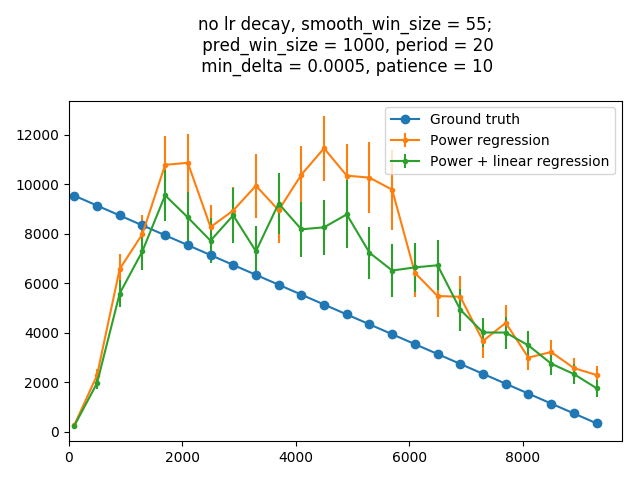

In [25]:
fig = plt.figure()
report_period = 20
# ground truth
x = (start_point+(np.arange(len(preds)))*report_period)*num_epochs_between_eval
plt.plot(x, earlyStoppingStep-x,'-o')
legend = ['Ground truth']

# three methods
for alg in all_preds:
    plt.errorbar(all_steps[alg], np.array(all_preds[alg])-np.array(all_steps[alg]), all_errs[alg], fmt='.-')
    legend.append(alg)
    
plt.xlim(0,earlyStoppingStep+100)
plt.legend(legend)
plt.title('no lr decay, smooth_win_size = {4};\n pred_win_size = {0}, period = {1}\n min_delta = {2}, patience = {3}\n '.
          format(pred_win_size, period, min_delta, patience, smooth_win_size))
fig.tight_layout()

# save the image
dir_ = '/Users/stranot/Desktop/zeros/cifar10_lr_1e_1/'
plt.savefig(dir_ + 'images/min_delta_{:.0e}_patience_{}.png'.format(min_delta, patience))

# # store the results
# for key in all_preds:
#     all_preds[key] = list(all_preds[key])
#     all_errs[key] = list(all_errs[key])
#     all_steps[key] = list(all_steps[key])
# output = {}
# output['all_preds'] = all_preds
# output['all_errs'] = all_errs
# output['all_steps'] = all_steps
# with open(dir_ + 'jsons/min_delta_{:.0e}_patience_{}.json'.format(min_delta, patience), 'w+') as f:
#     json.dump(output, f)